<a href="https://colab.research.google.com/github/ritwikraha/Open-Generative-Fill/blob/main/notebooks/open_generative_fill_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Installation

In [1]:
!pip install -qq git+https://github.com/ritwikraha/Open-Generative-Fill

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 103.7 MB/s eta 0:00:00


In [25]:
import torch

from open_generative_fill import config
from open_generative_fill.lm_models import run_lm_model
from open_generative_fill.load_data import load_image
from open_generative_fill.vision_models import (
    run_caption_model,
    run_inpainting_pipeline,
    run_segmentaiton_pipeline,
)

import matplotlib.pyplot as plt

In [23]:
# @title Enter values for generation
image_url = "https://i.imgur.com/4ujXoav.jpeg" # @param {type:"string"}
edit_prompt = "change the bottle to a wine" # @param {type:"string"}
seed_value = 41 # @param {type:"slider", min:0, max:100, step:1}

## Loading the Image and Models

In [15]:
# Set the device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GENERATOR = torch.Generator().manual_seed(seed_value)

# Load the image from the url and get the text prompt
image = load_image(image_url=image_url, image_size=config.IMAGE_SIZE)

## Image Captioning Models

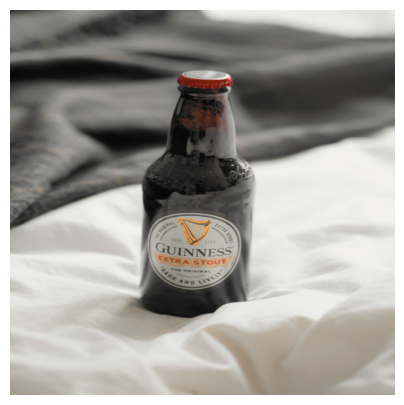

In [27]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

In [28]:
# Image captioning
caption = run_caption_model(
    model_id=config.CAPTION_MODEL_ID, image=image, device=DEVICE
)

print("#"*100)
print(f"Using caption model: {config.CAPTION_MODEL_ID}")
print(f"Caption: {caption}")
print("#"*100)

####################################################################################################
Using caption model: Salesforce/blip-image-captioning-base
Caption: a bottle of beer sitting on a bed
####################################################################################################


## Language Model

In [30]:
print(f"{edit_prompt=}")

edit_prompt='change the bottle to a wine'


In [31]:
# Language model
to_replace, replaced_caption = run_lm_model(
    model_id=config.LANGUAGE_MODEL_ID,
    caption=caption,
    edit_prompt=edit_prompt,
    device=DEVICE,
)

print("#"*100)
print(f"Using llm: {config.LANGUAGE_MODEL_ID}")
print(f"Object to replace: {to_replace}")
print(f"Caption for inpaint: {replaced_caption}")
print("#"*100)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


####################################################################################################
Using llm: Qwen/Qwen1.5-0.5B-Chat
Object to replace: bottle
Caption for inpaint: a wine glass sitting on a bed, elegant and sophisticated, with a glass of red wine on top, a touch of elegance and sophistication.
####################################################################################################


## Segmentation Model

In [32]:
# Segmentation pipeline
segmentation_mask = run_segmentaiton_pipeline(
    detection_model_id=config.DETECTION_MODEL_ID,
    segmentation_model_id=config.SEGMENTATION_MODEL_ID,
    to_replace=to_replace,
    image=image,
    device=DEVICE,
)

print("#"*100)
print(f"Using detection model: {config.DETECTION_MODEL_ID}")
print(f"Using segmentation model: {config.SEGMENTATION_MODEL_ID}")
print("#"*100)

####################################################################################################
Using detection model: google/owlv2-base-patch16-ensemble
Using segmentation model: facebook/sam-vit-base
####################################################################################################


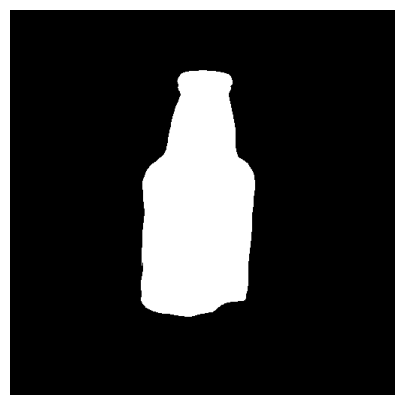

In [33]:
plt.figure(figsize=(5, 5))
plt.imshow(segmentation_mask)
plt.axis("off")
plt.show()

## Inpainting Model

In [34]:
# Inpainting pipeline
output = run_inpainting_pipeline(
    inpainting_model_id=config.INPAINTING_MODEL_ID,
    image=image,
    mask=segmentation_mask,
    replaced_caption=replaced_caption,
    image_size=config.IMAGE_SIZE,
    generator=GENERATOR,
    device=DEVICE,
)

print("#"*100)
print(f"Using diffusion model: {config.INPAINTING_MODEL_ID}")
print("#"*100)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/50 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

####################################################################################################
Using diffusion model: diffusers/stable-diffusion-xl-1.0-inpainting-0.1
####################################################################################################


## Final Output

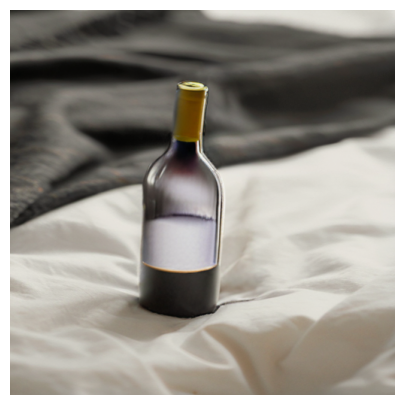

In [37]:
plt.figure(figsize=(5, 5))
plt.imshow(output)
plt.axis("off")
plt.show()